# Filtering the ECG

I do the following:

1. prepare the [Julia](https://julialang.org/) environment by importing the needed packages (libraries)

In [1]:
using Pkg; Pkg.activate("."); 
Pkg.precompile();
using Plots; plotlyjs()
using FFTW, DSP, CSV, Tables;

 Activating environment at `~/Documents/thesis.git/coding/01_exploration/Project.toml`


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-8460079453349190754\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-161397544995414560\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-8460079453349190754\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Precompiling project...


2. read in an [MITBIH](https://www.physionet.org/content/mitdb/1.0.0/) ECG file (number 100; downloaded and converted to csv using [WFDB](https://archive.physionet.org/physiotools/wfdb.shtml). The reading of the csv file is performed by [CSV.jl](https://github.com/JuliaData/CSV.jl)

In [2]:
ecg_matrix = CSV.File("../mitbih/100.mitbih") |> Tables.matrix;

3. extract a specific ECG curve from the file (sampling frequency of the ecg is 360 per second)

In [3]:
fs = 360     # 360 samples per second
N  = 2 * fs  # equivalent to 2 seconds

ecg = ecg_matrix[1:N, 1:2];

4. create a digital filter using [DSP.jl](https://github.com/JuliaDSP/DSP.jl) and filter the ECG signal with it

In [4]:
digital_filter = digitalfilter(Lowpass(0.2), Butterworth(1))
ecg_filtered = copy(ecg)
ecg_filtered[:,2] = filt(digital_filter, ecg[:,2]);

5. create a plot of the raw and filtered ECGs to compare them (using [Plots.jl](https://github.com/JuliaPlots/Plots.jl))

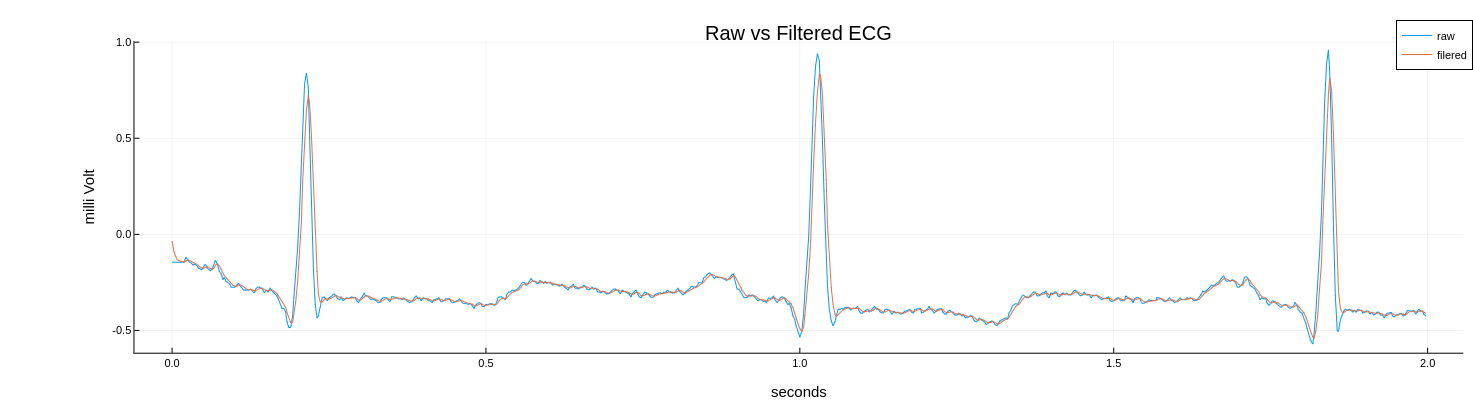

In [5]:
plot(ecg[:,1], ecg[:,2], title="Raw vs Filtered ECG", label="raw")
plot!(ecg_filtered[:,1], ecg_filtered[:,2], xlabel="seconds", ylabel="milli Volt", label="filered")

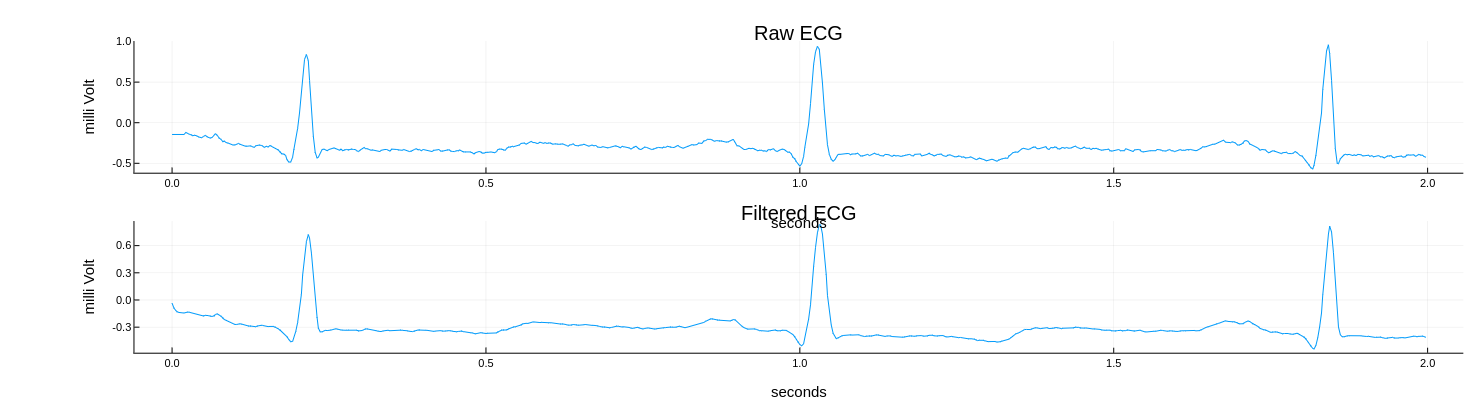

In [6]:
p1 = plot(ecg[:,1], ecg[:,2], title="Raw ECG", xlabel="seconds", ylabel="milli Volt")
p2 = plot(ecg_filtered[:,1], ecg_filtered[:,2], title="Filtered ECG", xlabel="seconds", ylabel="milli Volt")
plot(p1, p2, layout=(2,1), label="")

6. create Fourier Transforms of both ECGs using [FFTW.jl](https://github.com/JuliaMath/FFTW.jl)

In [7]:
F  = 1/N * fftshift(fft(ecg[:,2]))
F_filtered = 1/N * fftshift(fft(ecg_filtered[:,2]));

7. plot the Fourier Transforms

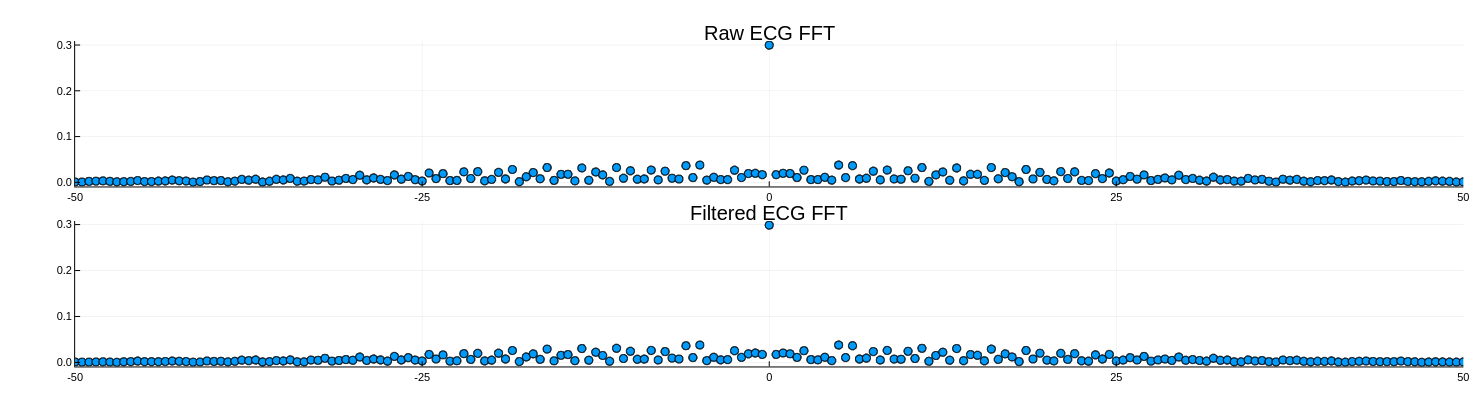

In [8]:
frequencies = ((-N/2):(N/2-1)) * fs / N

p1 = plot(frequencies, abs.(F), seriestype = :scatter, title="Raw ECG FFT", xlim=(-50,50))
p2 = plot(frequencies, abs.(F_filtered), seriestype = :scatter, title="Filtered ECG FFT", xlim=(-50,50))
plot(p1, p2, layout=(2,1), label="")

8. plot phase spectrums

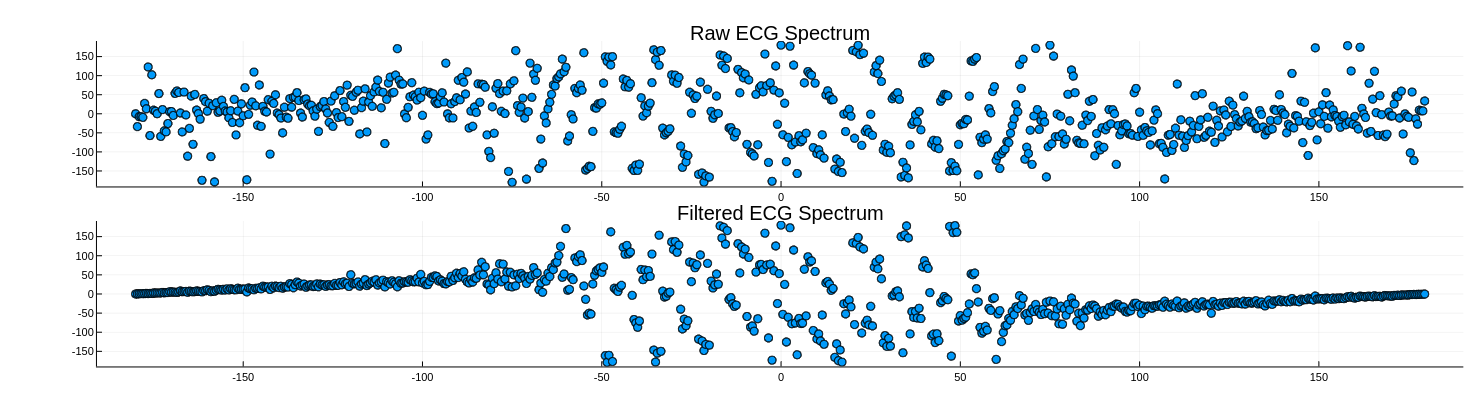

In [9]:
phase = [atan(imag(i), real(i)) for i in F] * 180 / pi
p1 = plot(frequencies, phase, seriestype = :scatter, label="", title="Raw ECG Spectrum")
phase_filtered = [atan(imag(i), real(i)) for i in F_filtered] * 180 / pi
p2 = plot(frequencies, phase_filtered, seriestype = :scatter, label="", title="Filtered ECG Spectrum")
plot(p1, p2, layout=(2,1), label="")